Install Kaggle API and download dataset

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload your Kaggle API key (you need to get this from your Kaggle account)
from google.colab import files
files.upload()  # Upload your kaggle.json file here

# Set up Kaggle API key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Unzip the dataset
!unzip -q intel-image-classification.zip -d dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 94% 326M/346M [00:02<00:00, 95.7MB/s]
100% 346M/346M [00:02<00:00, 138MB/s] 


Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix

Prepare the data

In [ ]:
# Define paths
train_dir = '/content/dataset/seg_train/seg_train'
test_dir = '/content/dataset/seg_test/seg_test'

# Get class names
class_names = os.listdir(train_dir)
num_classes = len(class_names)

print("Class names:", class_names)
print("Number of classes:", num_classes)

# Check number of images in each set
for cls in class_names:
    print(f"Train {cls}:", len(os.listdir(os.path.join(train_dir, cls))))
    print(f"Test {cls}:", len(os.listdir(os.path.join(test_dir, cls))))

# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32

Class names: ['buildings', 'sea', 'mountain', 'glacier', 'street', 'forest']
Number of classes: 6
Train buildings: 2191
Test buildings: 437
Train sea: 2274
Test sea: 510
Train mountain: 2512
Test mountain: 525
Train glacier: 2404
Test glacier: 553
Train street: 2382
Test street: 501
Train forest: 2271
Test forest: 474


 Data Augmentation and Generators

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Using 20% of training data for validation
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Build MobileNetV2 Model

In [ ]:
# Load MobileNetV2 base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,579,974 (13.66 MB)

 Trainable params: 1,319,942 (5.04 MB)

 Non-trainable params: 2,260,032 (8.62 MB)

Train the Model

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.6860 - loss: 0.9560
Epoch 1: val_accuracy improved from -inf to 0.86674, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 184s 490ms/step - accuracy: 0.6863 - loss: 0.9553 - val_accuracy: 0.8667 - val_loss: 0.3726 - learning_rate: 1.0000e-04
Epoch 2/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7188 - loss: 0.7285

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.86674
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7188 - loss: 0.7285 - val_accuracy: 0.8660 - val_loss: 0.3790 - learning_rate: 1.0000e-04
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8361 - loss: 0.4860
Epoch 3: val_accuracy improved from 0.86674 to 0.87572, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 202s 578ms/step - accuracy: 0.8361 - loss: 0.4860 - val_accuracy: 0.8757 - val_loss: 0.3485 - learning_rate: 1.0000e-04
Epoch 4/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.8750 - loss: 0.3870
Epoch 4: val_accuracy improved from 0.87572 to 0.88793, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8750 - loss: 0.3870 - val_accuracy: 0.8879 - val_loss: 0.3365 - learning_rate: 1.0000e-04
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8471 - loss: 0.4342
Epoch 5: val_accuracy did not improve from 0.88793
350/350 ━━━━━━━━━━━━━━━━━━━━ 187s 453ms/step - accuracy: 0.8471 - loss: 0.4342 - val_accuracy: 0.8642 - val_loss: 0.3866 - learning_rate: 1.0000e-04
Epoch 6/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8125 - loss: 0.4295
Epoch 6: val_accuracy did not improve from 0.88793
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.8125 - loss: 0.4295 - val_accuracy: 0.8764 - val_loss: 0.3579 - learning_rate: 1.0000e-04
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8599 - loss: 0.3826
Epoch 7: val_accuracy did not improve from 0.88793
350/350 ━━━━━━━━━━━━━━━━━━━━ 202s 569ms/step - accuracy: 0.8599 - loss: 0.3826 - val_accuracy: 0.8807 - val_loss: 0.3505 - learning_rate: 1

350/350 ━━━━━━━━━━━━━━━━━━━━ 203s 579ms/step - accuracy: 0.8662 - loss: 0.3775 - val_accuracy: 0.8890 - val_loss: 0.3333 - learning_rate: 2.0000e-05
Epoch 10/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8438 - loss: 0.3539
Epoch 10: val_accuracy did not improve from 0.88901
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.8438 - loss: 0.3539 - val_accuracy: 0.8876 - val_loss: 0.3178 - learning_rate: 2.0000e-05
Epoch 11/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8630 - loss: 0.3887
Epoch 11: val_accuracy improved from 0.88901 to 0.89583, saving model to best_model.h5


350/350 ━━━━━━━━━━━━━━━━━━━━ 162s 462ms/step - accuracy: 0.8630 - loss: 0.3886 - val_accuracy: 0.8958 - val_loss: 0.3008 - learning_rate: 2.0000e-05
Epoch 12/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8125 - loss: 0.6794
Epoch 12: val_accuracy did not improve from 0.89583
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.8125 - loss: 0.6794 - val_accuracy: 0.8897 - val_loss: 0.3157 - learning_rate: 2.0000e-05
Epoch 13/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8741 - loss: 0.3630
Epoch 13: val_accuracy did not improve from 0.89583
350/350 ━━━━━━━━━━━━━━━━━━━━ 201s 553ms/step - accuracy: 0.8741 - loss: 0.3630 - val_accuracy: 0.8937 - val_loss: 0.3112 - learning_rate: 2.0000e-05
Epoch 14/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.8750 - loss: 0.4345
Epoch 14: val_accuracy did not improve from 0.89583
350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 120ms/step - accuracy: 0.8750 - loss: 0.4345 - val_accuracy: 0.8840 - val_loss: 0.3195 - learning_r

350/350 ━━━━━━━━━━━━━━━━━━━━ 163s 464ms/step - accuracy: 0.8743 - loss: 0.3392 - val_accuracy: 0.8991 - val_loss: 0.2979 - learning_rate: 1.0000e-05
Epoch 22/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8125 - loss: 0.3300
Epoch 22: val_accuracy did not improve from 0.89907
350/350 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.8125 - loss: 0.3300 - val_accuracy: 0.8973 - val_loss: 0.3021 - learning_rate: 1.0000e-05
Epoch 23/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8794 - loss: 0.3305
Epoch 23: val_accuracy did not improve from 0.89907
350/350 ━━━━━━━━━━━━━━━━━━━━ 200s 554ms/step - accuracy: 0.8794 - loss: 0.3305 - val_accuracy: 0.8944 - val_loss: 0.3045 - learning_rate: 1.0000e-05
Epoch 24/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.9375 - loss: 0.2174
Epoch 24: val_accuracy did not improve from 0.89907
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.9375 - loss: 0.2174 - val_accuracy: 0.8940 - val_loss: 0.2992 - learning_ra

350/350 ━━━━━━━━━━━━━━━━━━━━ 202s 555ms/step - accuracy: 0.8758 - loss: 0.3378 - val_accuracy: 0.9012 - val_loss: 0.2797 - learning_rate: 1.0000e-05
Epoch 28/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8438 - loss: 0.5301
Epoch 28: val_accuracy did not improve from 0.90122
350/350 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.8438 - loss: 0.5301 - val_accuracy: 0.8966 - val_loss: 0.2961 - learning_rate: 1.0000e-05
Epoch 29/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8832 - loss: 0.3070
Epoch 29: val_accuracy did not improve from 0.90122
350/350 ━━━━━━━━━━━━━━━━━━━━ 198s 462ms/step - accuracy: 0.8832 - loss: 0.3070 - val_accuracy: 0.8919 - val_loss: 0.3038 - learning_rate: 1.0000e-05
Epoch 30/30
  1/350 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8750 - loss: 0.3682
Epoch 30: val_accuracy did not improve from 0.90122
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.8750 - loss: 0.3682 - val_accuracy: 0.8966 - val_loss: 0.3015 - learning_ra

Fine-tuning

In [ ]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=15,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7645 - loss: 0.6714
Epoch 1: val_accuracy did not improve from 0.90122
350/350 ━━━━━━━━━━━━━━━━━━━━ 208s 512ms/step - accuracy: 0.7646 - loss: 0.6712 - val_accuracy: 0.8800 - val_loss: 0.4010 - learning_rate: 1.0000e-05
Epoch 2/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.7812 - loss: 0.6347
Epoch 2: val_accuracy did not improve from 0.90122
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7812 - loss: 0.6347 - val_accuracy: 0.8825 - val_loss: 0.3810 - learning_rate: 1.0000e-05
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8293 - loss: 0.4939
Epoch 3: val_accuracy did not improve from 0.90122
350/350 ━━━━━━━━━━━━━━━━━━━━ 201s 575ms/step - accuracy: 0.8294 - loss: 0.4939 - val_accuracy: 0.8901 - val_loss: 0.3801 - learning_rate: 1.0000e-05
Epoch 4/15
  1/350 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.9062 - loss: 0.3186
Epoch 4: val_accuracy did not improve from 0.90122

Evaluate the Model

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9144 - loss: 0.2323

Test accuracy: 0.9063
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       437
         sea       0.99      0.99      0.99       474
    mountain       0.84      0.82      0.83       553
     glacier       0.84      0.85      0.84       525
      street       0.93      0.95      0.94       510
      forest       0.93      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



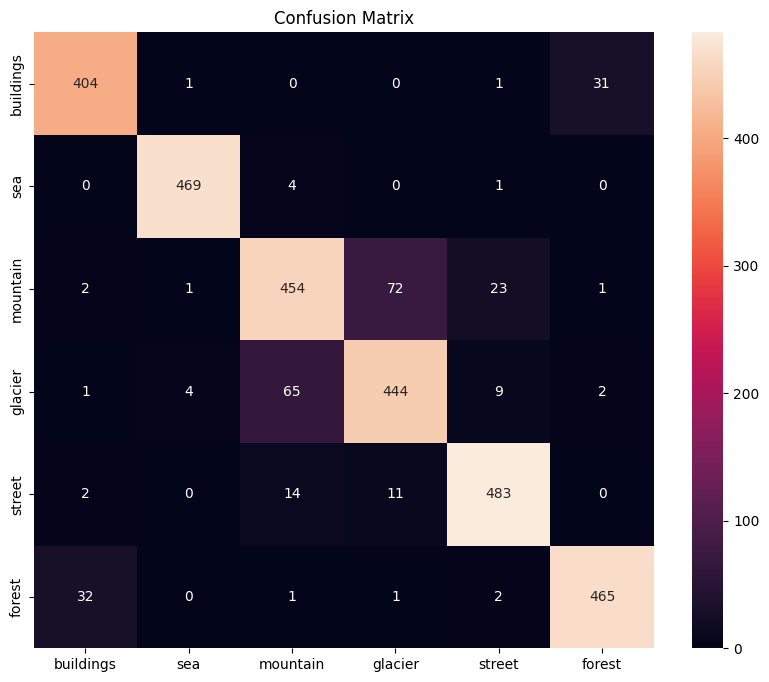

In [ ]:
# Load best model
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')

# Generate predictions
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.show()

Visualize Results